In [1]:
import ast
import math
from typing import List
import warnings
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import spacy

warnings.filterwarnings(action='ignore', category=RuntimeWarning)

/home/nshafiabadi/anaconda3/envs/virtualenv/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
def plot_surprisals(words:List[str], surprisals_df):
    num_words = len(words)
    cols = min(num_words, 3)
    rows = math.ceil(num_words / cols)

    plt.style.use('ggplot')
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = np.atleast_2d(axs)

    for i, word in enumerate(words):   
        word_data = surprisals_df[surprisals_df['Token'] == word].iloc[1:]  # mention this
        if word_data.empty:
            print(f'No data found for the word "{word}"')
            continue

        ax = axs[i//cols, i%cols]
        ax.plot(word_data['Steps'], word_data['MeanSurprisal'], marker='o')
        ax.set_title(f'"{word}"')
        ax.set_xlabel('Steps (log10)')
        ax.set_ylabel('Mean surprisal')
        # ax.set_xscale('log')
        ax.invert_yaxis()

    # Remove empty subplots
    for j in range(i+1, rows*cols):
        fig.delaxes(axs.flatten()[j])

    plt.tight_layout()
    plt.show()


In [3]:
wikitext_surprisals = '../data/wikitext/bert_surprisals_large.txt'
surprisals = pd.read_csv(wikitext_surprisals, delimiter='\t')

In [4]:
surprisals = (surprisals
    .sort_values(['Token', 'Steps'])
    .groupby('Token')
    .apply(lambda x: x.assign(MeanSurprisalDiff = x['MeanSurprisal'].diff().fillna(0), 
                              StdevSurprisalDiff = x['StdevSurprisal'].diff().fillna(0)))
    .reset_index(drop=True))

surprisals.insert(0, 'Token', surprisals.pop('Token'))
surprisals = surprisals[surprisals['Token'].apply(lambda t: t.isascii() and not t.isdigit())]
surprisals

/tmp/ipykernel_3260015/3822632482.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(MeanSurprisalDiff = x['MeanSurprisal'].diff().fillna(0),


,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff
522,100th,0,8265,14.729807,0.114784,0.0,2,0.000000,0.000000
523,100th,20000,10,6.275679,0.571626,0.0,2,-8.454128,0.456843
524,100th,40000,14,7.686354,0.907284,0.0,2,1.410675,0.335658
525,100th,60000,5,6.205370,1.967315,0.0,2,-1.480984,1.060031
526,100th,80000,2,5.086202,1.475961,0.0,2,-1.119168,-0.491355
...,...,...,...,...,...,...,...,...,...
284282,zu,1600000,0,2.632001,3.066978,0.5,4,-0.153028,-0.168203
284283,zu,1700000,0,2.860503,3.312823,0.5,4,0.228502,0.245846
284284,zu,1800000,0,2.903762,3.357431,0.5,4,0.043259,0.044608
284285,zu,1900000,0,2.735918,3.165675,0.5,4,-0.167844,-0.191756


In [6]:
surprisals['Token'].nunique()

9239

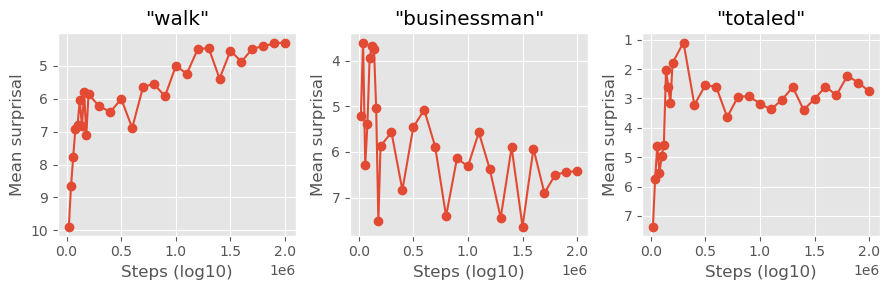

In [9]:
random_1 = random.choice(surprisals['Token'].unique().tolist())
random_2 = random.choice(surprisals['Token'].unique().tolist())
plot_surprisals(['walk', random_1, random_2], surprisals)

### Most vs least frequent words

Percentage of frequent words in the dataset (occuring at least 512 times): 0.17%
Percentage of infrequent words in the dataset (occuring only once): 26.93%


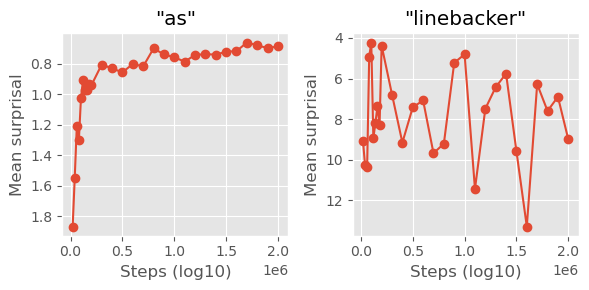

In [10]:
frequent = surprisals[surprisals['NumExamples'] == 512]
infrequent = surprisals[surprisals['NumExamples'] == 1]

print(f'Percentage of frequent words in the dataset (occuring at least 512 times): {len(frequent)/len(surprisals)*100:.2f}%')
print(f'Percentage of infrequent words in the dataset (occuring only once): {len(infrequent)/len(surprisals)*100:.2f}%')

plot_surprisals(
    frequent['Token'].drop_duplicates().sample(1).tolist() + infrequent['Token'].drop_duplicates().sample(1).tolist(), 
    surprisals
    )

Frequent words (>= 512 examples):
Min surprisal: 0.69
Max surprisal (excluding the first step): 1.82
Average variability (excluding the first step): -0.04

Inrequent words (= 1 example):
Min surprisal: 6.09
Max surprisal (excluding the first step): 10.85
Average variability (excluding the first step): -0.18

Full corpus:
Min surprisal: 4.91
Max surprisal (excluding the first step): 9.13
Average variability (excluding the first step): -0.16


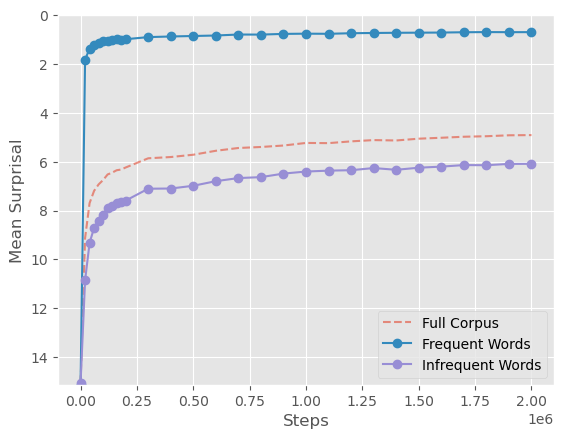

In [38]:
# for each step, average surprisal across all words with at least 512 examples (frequent words)
avg_freq_surprisals = frequent.groupby('Steps').MeanSurprisal.mean().reset_index().assign(Diffs=lambda x: x.MeanSurprisal.diff().fillna(0))

# for each step, average surprisal across all words with only 1 example (infrequent words)
avg_infreq_surprisals = infrequent.groupby('Steps').MeanSurprisal.mean().reset_index().assign(Diffs=lambda x: x.MeanSurprisal.diff().fillna(0))

# for each step, average surprisal across all words
avg_surprisals = surprisals.groupby('Steps').MeanSurprisal.mean().reset_index().assign(Diffs=lambda x: x.MeanSurprisal.diff().fillna(0))

plt.figure()
# plt.xscale('log')
# plt.yscale('log')

plt.plot(avg_surprisals.Steps, avg_surprisals.MeanSurprisal, linestyle='--', alpha=0.6, label='Full Corpus')
plt.plot(avg_freq_surprisals.Steps, avg_freq_surprisals.MeanSurprisal, marker='o', label='Frequent Words')
plt.plot(avg_infreq_surprisals.Steps, avg_infreq_surprisals.MeanSurprisal, marker='o', label='Infrequent Words')

plt.ylim(max(avg_freq_surprisals.MeanSurprisal.max(), avg_infreq_surprisals.MeanSurprisal.max()), 0)
plt.xlabel('Steps')
plt.ylabel('Mean Surprisal')
plt.legend()

print('Frequent words (>= 512 examples):')
print(f"Min surprisal: {avg_freq_surprisals.MeanSurprisal.min():.2f}")
print(f"Max surprisal (excluding the first step): {avg_freq_surprisals.MeanSurprisal.iloc[1:].max():.2f}")
print(f"Average variability (excluding the first step): {avg_freq_surprisals.Diffs.iloc[2:].mean():.2f}\n")

print('Inrequent words (= 1 example):')
print(f"Min surprisal: {avg_infreq_surprisals.MeanSurprisal.min():.2f}")
print(f"Max surprisal (excluding the first step): {avg_infreq_surprisals.MeanSurprisal.iloc[1:].max():.2f}")
print(f"Average variability (excluding the first step): {avg_infreq_surprisals.Diffs.iloc[2:].mean():.2f}\n")

print('Full corpus:')
print(f"Min surprisal: {avg_surprisals.MeanSurprisal.min():.2f}")
print(f"Max surprisal (excluding the first step): {avg_surprisals.MeanSurprisal.iloc[1:].max():.2f}")
print(f"Average variability (excluding the first step): {avg_surprisals.Diffs.iloc[2:].mean():.2f}")

plt.show()

In [14]:
# plot_surprisals(bert_surprisals['Token'].drop_duplicates().tolist(), bert_surprisals)

### Words with different POS

In [49]:
def get_pos_tags(doc_path):
    nlp = spacy.load('en_core_web_sm')
    nlp.max_length = 2000000
    pos_dict = {}
    with open(doc_path, 'r', encoding='utf-8') as file:
        text = file.read()
        doc = nlp(text)
        for token in doc:
            if token.text.lower() in pos_dict and not token.pos_ in pos_dict[token.text.lower()]:
                pos_dict[token.text.lower()].append(token.pos_)
            else:
                pos_dict[token.text.lower()] = [token.pos_]
        
    return pd.DataFrame(list(pos_dict.items()), columns=['Token', 'POS'])

In [25]:
def plot_pos_avg(dfs: List[pd.DataFrame]):
    plt.style.use('ggplot')
    plt.figure()
    max_y = 0
    min_y = float('inf')
    for df in dfs:
        avg = (df.groupby('Steps')
                 .agg({'MeanSurprisal': 'mean', 'POS': 'first'})
                 .reset_index()
                 .assign(Diffs=lambda x: x['MeanSurprisal'].diff().fillna(0)))

        plt.plot(avg['Steps'], avg['MeanSurprisal'], 
                 label=f"{avg['POS'].values[0][0]} (var: {avg['Diffs'].iloc[2:].mean():.2f})")
        max_y = avg['MeanSurprisal'].max() if avg['MeanSurprisal'].max() > max_y else max_y
        min_y = avg['MeanSurprisal'].min() if avg['MeanSurprisal'].min() < min_y else min_y

    plt.ylim(max_y, 0)
    plt.xlabel('Steps')
    plt.ylabel('Mean Surprisal')
    # plt.xscale('log')
    plt.legend()
    plt.show()

In [50]:
document = "../data/wikitext/wikitext103_test.txt"
pos_tags = get_pos_tags(document)
pos_tags

,Token,POS
0,,[SPACE]
1,robert,[PROPN]
2,boulter,[PROPN]
3,is,[AUX]
4,an,[DET]
...,...,...
18746,parlayed,[VERB]
18747,credibility,[NOUN]
18748,ronnie,[PROPN]
18749,pelkey,[PROPN]


In [51]:
merged_df = pd.merge(surprisals, pos_tags, on='Token', how='inner')
merged_df.to_csv('../results/wikitext_surprisals_diffs_pos.csv', sep='\t', index=False)

In [52]:
surps_with_pos = pd.read_csv('../results/wikitext_surprisals_diffs_pos.csv', sep='\t')
surps_with_pos['POS'] = surps_with_pos['POS'].apply(ast.literal_eval)
surps_with_pos

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
0,100th,0,8265,14.729807,0.114784,0.0,2,0.000000,0.000000,[ADJ]
1,100th,20000,10,6.275679,0.571626,0.0,2,-8.454128,0.456843,[ADJ]
2,100th,40000,14,7.686354,0.907284,0.0,2,1.410675,0.335658,[ADJ]
3,100th,60000,5,6.205370,1.967315,0.0,2,-1.480984,1.060031,[ADJ]
4,100th,80000,2,5.086202,1.475961,0.0,2,-1.119168,-0.491355,[ADJ]
...,...,...,...,...,...,...,...,...,...,...
267926,zu,1600000,0,2.632001,3.066978,0.5,4,-0.153028,-0.168203,[NOUN]
267927,zu,1700000,0,2.860503,3.312823,0.5,4,0.228502,0.245846,[NOUN]
267928,zu,1800000,0,2.903762,3.357431,0.5,4,0.043259,0.044608,[NOUN]
267929,zu,1900000,0,2.735918,3.165675,0.5,4,-0.167844,-0.191756,[NOUN]


In [53]:
all_pos_tags = set([pos for pos_list in surps_with_pos['POS'] if isinstance(pos_list, list) for pos in pos_list])
all_pos_tags

{'ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'SCONJ',
 'VERB',
 'X'}

In [54]:
num_nouns = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'NOUN' in pos_list)]['Token'].nunique()
num_verbs = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'VERB' in pos_list)]['Token'].nunique()
num_adjs = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'ADJ' in pos_list)]['Token'].nunique()
num_advs = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'ADV' in pos_list)]['Token'].nunique()

print(f"Total number of nouns: {num_nouns}")
print(f"Total number of verbs: {num_verbs}")
print(f"Total number of adjectives: {num_adjs}")
print(f"Total number of adverbs: {num_advs}")

Total number of nouns: 4606
Total number of verbs: 2685
Total number of adjectives: 1337
Total number of adverbs: 397


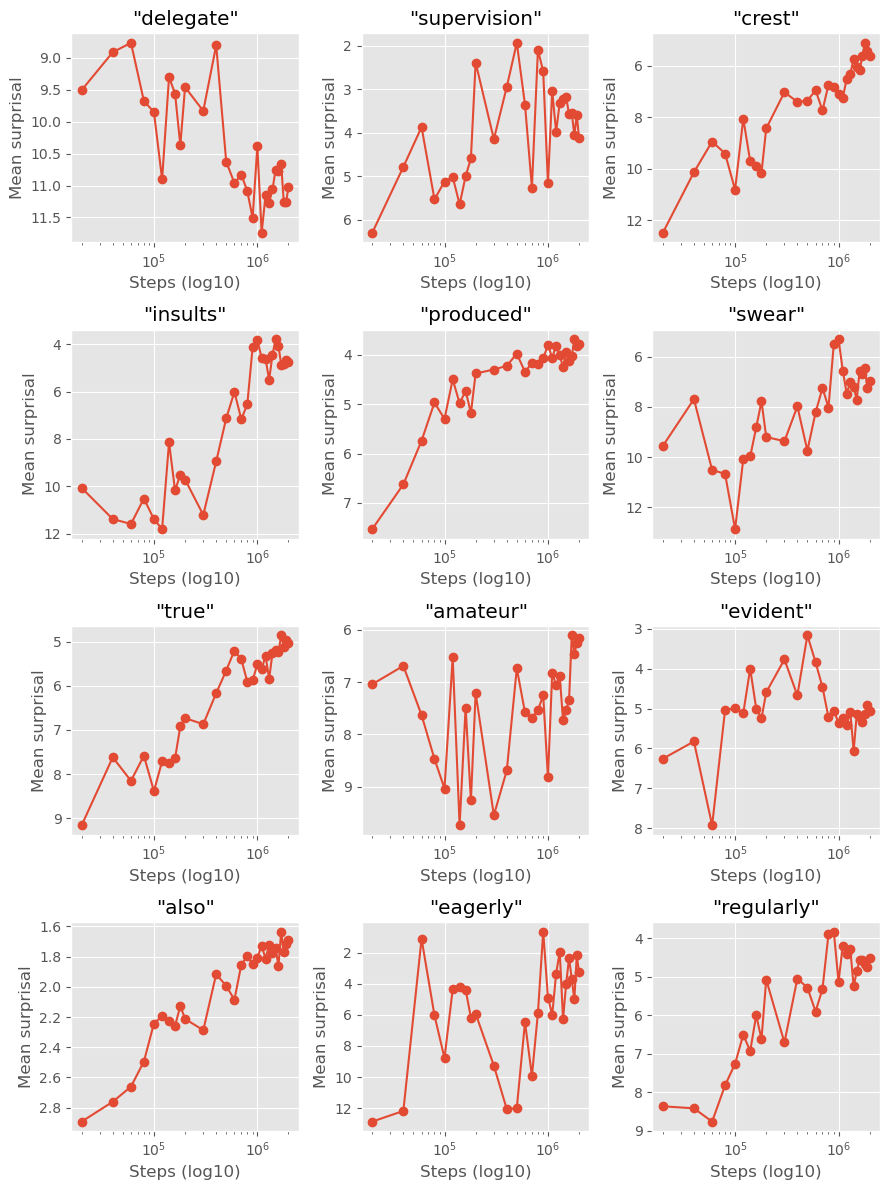

In [55]:
noun = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'NOUN' in pos_list and len(pos_list) == 1)]
verb = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'VERB' in pos_list and len(pos_list) == 1)]
adj = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'ADJ' in pos_list and len(pos_list) == 1)]
adv = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'ADV' in pos_list and len(pos_list) == 1)]

noun_sample = noun['Token'].drop_duplicates().sample(3).tolist()
verb_sample = verb['Token'].drop_duplicates().sample(3).tolist()
adj_sample = adj['Token'].drop_duplicates().sample(3).tolist()
adv_sample = adv['Token'].drop_duplicates().sample(3).tolist()

plot_surprisals(
    noun_sample + verb_sample + adj_sample + adv_sample, 
    surps_with_pos
    )

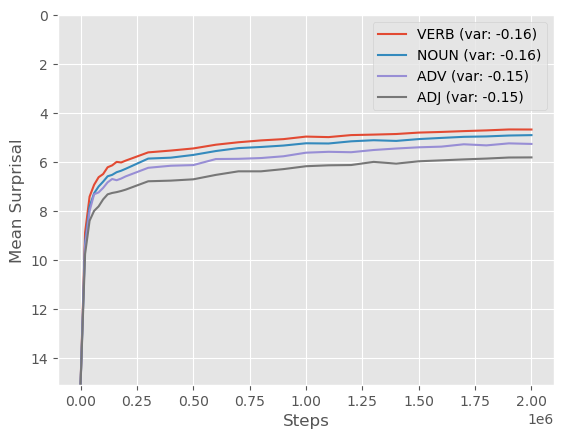

In [56]:
plot_pos_avg([verb, noun, adv, adj])

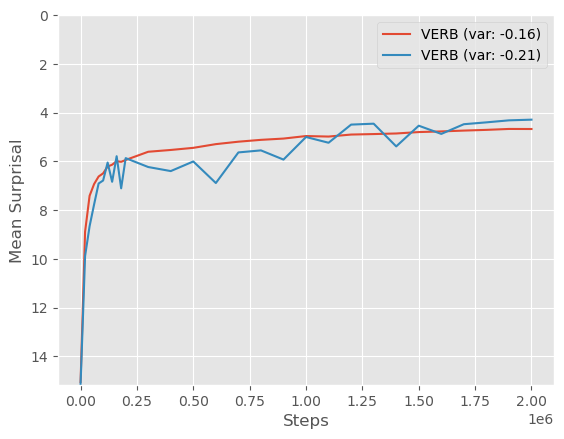

In [57]:
plot_pos_avg([verb, verb[verb['Token'] == 'walk']])

### Top 5 largest and smallest absolute diffs

In [23]:
largest_abs_diffs = merged_df.loc[merged_df['MeanSurprisalDiff'].abs().nlargest(5).index]
largest_abs_diffs

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
165830,overland,160000,0,0.943717,NaN,1.000000,1,-18.673972,0.000000,[ADJ]
165829,overland,140000,3784,19.617689,NaN,0.000000,1,18.445852,0.000000,[ADJ]
264394,winding,20000,0,0.276744,NaN,1.000000,1,-15.882928,0.000000,[NOUN]
154020,mph,20000,0,0.809797,0.855897,0.722222,36,-15.831713,0.505971,[NOUN]
37875,certified,20000,0,0.030636,0.038263,1.000000,6,-15.704447,-0.227175,[VERB]


In [24]:
smallest_abs_diffs = merged_df[merged_df['Steps'] != 0].sort_values(by='MeanSurprisalDiff', key=abs).head(5)
smallest_abs_diffs

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
42657,climate,1900000,0,0.000217,NaN,1.000000,1,0.000003,0.000000,[NOUN]
27223,blanche,1300000,0,0.000060,NaN,1.000000,1,-0.000003,0.000000,[NOUN]
85027,enterprise,2000000,0,0.000739,NaN,1.000000,1,-0.000005,0.000000,[NOUN]
106539,general,1400000,0,2.829044,3.222019,0.540541,74,0.000006,0.106203,"[NOUN, ADJ]"
236607,swap,1700000,0,0.032646,NaN,1.000000,1,0.000007,0.000000,[NOUN]


In [25]:
largest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nlargest(5, 'MeanSurprisalDiff')).reset_index(drop=True)
largest_diffs[largest_diffs['Steps'] != 0]

/tmp/ipykernel_1815312/1962239088.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  largest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nlargest(5, 'MeanSurprisalDiff')).reset_index(drop=True)


,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
5,runaway,20000,10891,27.716341,NaN,0.0,1,11.962032,0.0,[NOUN]
6,regulated,20000,18807,25.066656,NaN,0.0,1,10.712674,0.0,[VERB]
7,mirage,20000,23455,24.396673,NaN,0.0,1,9.265528,0.0,[NOUN]
8,dwarfs,20000,11869,24.672249,NaN,0.0,1,8.909644,0.0,[VERB]
9,1800s,20000,19785,24.529793,NaN,0.0,1,8.891719,0.0,[NUM]
...,...,...,...,...,...,...,...,...,...,...
140,pets,2000000,31,8.665066,NaN,0.0,1,3.199545,0.0,[NOUN]
141,linebacker,2000000,20,8.995472,NaN,0.0,1,2.095737,0.0,[NOUN]
142,confesses,2000000,19,13.613836,NaN,0.0,1,1.756527,0.0,[VERB]
143,rotational,2000000,81,13.154806,NaN,0.0,1,1.632592,0.0,[ADJ]


In [26]:
smallest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nsmallest(5, 'MeanSurprisalDiff')).reset_index(drop=True)
smallest_diffs[smallest_diffs['Steps'] != 0]

/tmp/ipykernel_1815312/3927067076.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smallest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nsmallest(5, 'MeanSurprisalDiff')).reset_index(drop=True)


,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
5,winding,20000,0,0.276744,NaN,1.000000,1,-15.882928,0.000000,[NOUN]
6,mph,20000,0,0.809797,0.855897,0.722222,36,-15.831713,0.505971,[NOUN]
7,certified,20000,0,0.030636,0.038263,1.000000,6,-15.704447,-0.227175,[VERB]
8,s,20000,0,0.126845,0.742376,0.986328,512,-15.664729,0.336020,[PART]
9,reel,20000,0,0.018519,NaN,1.000000,1,-15.626365,0.000000,[NOUN]
...,...,...,...,...,...,...,...,...,...,...
140,blazing,2000000,3,5.174299,NaN,0.000000,1,-2.123194,0.000000,[VERB]
141,belongings,2000000,6,8.735147,NaN,0.000000,1,-1.822979,0.000000,[NOUN]
142,gender,2000000,4,6.109085,NaN,0.000000,1,-1.589911,0.000000,[NOUN]
143,insect,2000000,42,9.497608,NaN,0.000000,1,-1.562958,0.000000,[PROPN]


In [27]:
largest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nlargest(1).index])
largest_abs_diffs[largest_abs_diffs['Steps'] != 0]

/tmp/ipykernel_1815312/2835847893.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  largest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nlargest(1).index])


,,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
Steps,,,,,,,,,,,
20000,264394,winding,20000,0,0.276744,NaN,1.0,1,-15.882928,0.000000,[NOUN]
40000,90772,experimental,40000,1,2.001800,NaN,0.0,1,-11.768147,0.000000,[ADJ]
60000,78912,eagerly,60000,0,1.116366,NaN,1.0,1,-11.060543,0.000000,[ADV]
80000,222492,solving,80000,0,0.401181,NaN,1.0,1,-10.395129,0.000000,[VERB]
100000,14621,archdeacon,100000,5,5.331407,1.912436,0.0,2,-7.777198,-9.514957,[NOUN]
120000,142686,magnetic,120000,0,2.451734,NaN,1.0,1,-9.792418,0.000000,[ADJ]
140000,165829,overland,140000,3784,19.617689,NaN,0.0,1,18.445852,0.000000,[ADJ]
160000,165830,overland,160000,0,0.943717,NaN,1.0,1,-18.673972,0.000000,[ADJ]
180000,216610,shirt,180000,4248,17.229160,NaN,0.0,1,10.491095,0.000000,[NOUN]


In [28]:
smallest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nsmallest(1).index])
smallest_abs_diffs[smallest_abs_diffs['Steps'] != 0]

/tmp/ipykernel_1815312/584872678.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smallest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nsmallest(1).index])


,,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
Steps,,,,,,,,,,,
20000,27667,bliss,20000,1581,14.620508,NaN,0.000000,1,0.000615,0.000000,[NOUN]
40000,85001,enterprise,40000,0,0.059089,NaN,1.000000,1,-0.000298,0.000000,[NOUN]
60000,23493,battalions,60000,1,4.170025,4.221395,0.428571,14,0.000020,-0.602859,[NOUN]
80000,41532,claimed,80000,3,4.379226,1.781143,0.210526,19,-0.000084,-0.076557,[VERB]
100000,111307,guilty,100000,0,0.029458,0.016144,1.000000,2,0.000139,0.006831,[ADJ]
120000,194770,references,120000,0,3.665914,3.650630,0.600000,10,0.000019,0.009496,[NOUN]
140000,18567,attached,140000,2,4.222999,2.400314,0.090909,11,-0.000039,-0.338965,[VERB]
160000,79787,economic,160000,3,4.208651,1.772237,0.100000,10,-0.000113,-0.367980,[ADJ]
180000,175778,pledged,180000,14,6.328715,NaN,0.000000,1,-0.000036,0.000000,[VERB]
